In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms as T
from matplotlib import pyplot as plt
import numpy as np


In [2]:
mnist = MNIST(
    "../mnist",
    train=True,
    download=True,
    transform=T.Compose(
        [
            T.ToTensor(),
            T.Lambda(lambda x: torch.flatten(x)),
        ]
    ),
)
loader = DataLoader(mnist, batch_size=10000, shuffle=False)


In [3]:
device = "cuda"


def initparams(model: nn.Module):
    for param in model.parameters():
        torch.manual_seed(42)
        param.data = nn.Parameter(torch.randn(param.data.shape)).to(device)


net1 = nn.Sequential(nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10)).to(device)
net2 = nn.Sequential(
    nn.Linear(784, 256), nn.BatchNorm1d(784), nn.ReLU(), nn.Linear(256, 10)
).to(device)
initparams(net1)
initparams(net2)
lossfun = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net1.parameters(), lr=0.01)
optimizer2 = optim.SGD(net2.parameters(), lr=0.01)


def train(net, optimizer, epochs=10):
    for i in range(epochs):
        for j, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss = lossfun(y_hat, y)
            optimizer.zero_grad(True)
            loss.backward()
            optimizer.step()



In [4]:
train(net1, optimizer1)


In [5]:
train(net1, optimizer2)



In [14]:
def get_norm_weights(net: nn.Module):
    normWeights = None
    for param in net.parameters():
        flattenedWeights = torch.flatten(param.data).cpu()
        normWeights = flattenedWeights**2 if normWeights == None else torch.hstack((normWeights, flattenedWeights**2))
    return normWeights

In [15]:
norm_weights1 = get_norm_weights(net1)
norm_weights2 = get_norm_weights(net2)

In [ ]:
x1,b1 = np.histogram(norm_weights1)
x2,b2 = np.histogram(norm_weights2)

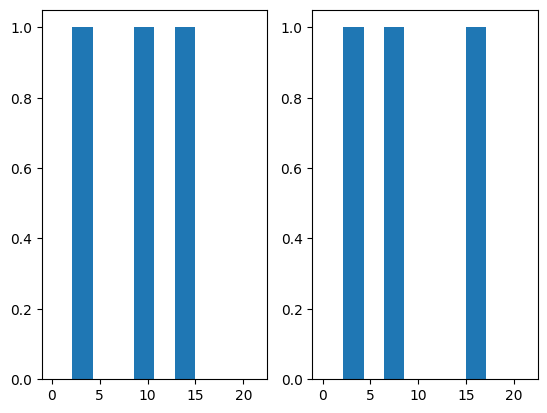

In [16]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(x1,b1)
axs[1].hist(x2,b2)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from lib.models import ConvNet4
from conv5 import (
    ConvNet5,
    convblock_normal,
    convblock_mobile,
    convblock_mobile2,
    calcParams,
)
from lib.utils import create_dataloaders
import itertools

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Running on device: {device}")



In [ ]:
def train_and_evaluate(net, num_epochs=10) -> None:
    """Train and evaluate the given model

    Args:
        net: CNN model to train
        num_epochs: Number of epochs to train

    """
    net = net.to(device)

    # Define a Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    # Get dataloaders
    trainloader, testloader = create_dataloaders()
    losses = torch.zeros(num_epochs)
    net.train()
    # Train the network
    for epoch in range(num_epochs):
        avg_loss = 0.0
        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
        losses[epoch] = avg_loss / len(trainloader)

    print("Finished Training")

    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return losses, acc



In [ ]:
hyperParams = {
    "convblock_variant": [convblock_mobile2],
    "preserve_size_after_conv_layer": [True],
    "num_conv_blocks": [4, 6, 8],
    "initial_num_channels_power": [5, 6, 7],
    "pooldegree": [2, 4, 8],
}



In [ ]:
def cond(**kwargs):
    preserve_size_after_conv_layer = kwargs["preserve_size_after_conv_layer"]
    num_conv_blocks = kwargs["num_conv_blocks"]
    pooldegree = kwargs["pooldegree"]

    _, calc_out_size, __ = calcParams(preserve_size_after_conv_layer, pooldegree)

    last_activation_size = calc_out_size(32, num_conv_blocks)
    if pooldegree != None:
        last_activation_size //= pooldegree
    return last_activation_size > 0


def hyperparamGen(condition=lambda **_: True, **kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        config = dict(zip(keys, instance))
        if condition(**config):
            yield config


for i, kwargs in enumerate(hyperparamGen(condition=cond, **hyperParams)):
    print(f"{i}) {kwargs}")


In [ ]:
maxacc = 0
maxi = None
for i, kwargs in enumerate(hyperparamGen(condition=cond, **hyperParams)):
    print(f"{i}) {kwargs}")
    filenameparams = "_".join(
        [
            v.__name__ if hasattr(v, "__name__") else f"{k}_{v}"
            for k, v in kwargs.items()
        ]
    )
    filename = f"results/conv5_{filenameparams}.txt"
    with open(filename, "w") as f:
        torch.manual_seed(1337)  # for deterministic runs
        net = ConvNet5(**kwargs)
        numel = 0
        for param in net.parameters():
            numel += param.numel()
        print(f"Number of params: {numel}", file=f)
        losses, acc = train_and_evaluate(net)
        print(f"Accuracy of the network on test images:{acc}", file=f)
        if acc > maxacc:
            maxacc = acc
            maxi = i
print(f"Best hyperparams:{list(hyperparamGen(lambda **_: True, **hyperParams))[maxi]}")
print(f"Best acc:{maxacc}")
